In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import log_loss,accuracy_score,roc_curve,auc

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [2]:
df_final_train= pd.read_hdf('storage_sample_stage4.h5','train_df', mode='r')
df_final_test= pd.read_hdf('storage_sample_stage4.h5','test_df',mode='r')

# FEATURIZATIONS

- Adding features like preferential attahment score for followers and followees & svd dot feature.

In [3]:
def preferential_attachment(data):
    prefrential_score=[]
    no_of_followers_s=data['num_followers_s']
    no_of_followers_d=data['num_followers_d']
    for i in range (len(data)):
        score=no_of_followers_s[i]*no_of_followers_d[i]
        prefrential_score.append(score)
    return prefrential_score

In [4]:
def preferential_attachment_followees(data):
    prefrential_score_followees=[]
    no_of_followees_s=data['num_followees_s']
    no_of_followees_d=data['num_followees_d']
    for i in range (len(data)):
        score=no_of_followees_s[i]*no_of_followees_d[i]
        prefrential_score_followees.append(score)
    return prefrential_score_followees
    

In [6]:
def svd_dot_v(data):
    
    dot_product_v=[]
    for i in range(len(data['svd_v_s_1'])):
        svd_v_s=[]
        svd_v_d=[]
        svd_v_s.append(data['svd_v_s_1'][i])
        svd_v_s.append(data['svd_v_s_2'][i])
        svd_v_s.append(data['svd_v_s_3'][i])
        svd_v_s.append(data['svd_v_s_4'][i])
        svd_v_s.append(data['svd_v_s_5'][i])
        svd_v_s.append(data['svd_v_s_6'][i])
        
        svd_v_d.append(data['svd_v_d_1'][i])
        svd_v_d.append(data['svd_v_d_2'][i])
        svd_v_d.append(data['svd_v_d_3'][i])
        svd_v_d.append(data['svd_v_d_4'][i])
        svd_v_d.append(data['svd_v_d_5'][i])
        svd_v_d.append(data['svd_v_d_6'][i])
        
        dot_product_v.append(np.dot(svd_v_s,svd_v_d))
    
    return dot_product_v
    

In [7]:
def svd_dot_u(data):
   
    dot_product=[]
    for i in range(len(data['svd_u_s_1'])):
        svd_u_s=[]
        svd_u_d=[]
        svd_u_s.append(data['svd_u_s_1'][i])
        svd_u_s.append(data['svd_u_s_2'][i])
        svd_u_s.append(data['svd_u_s_3'][i])
        svd_u_s.append(data['svd_u_s_4'][i])
        svd_u_s.append(data['svd_u_s_5'][i])
        svd_u_s.append(data['svd_u_s_6'][i])
        
        svd_u_d.append(data['svd_u_d_1'][i])
        svd_u_d.append(data['svd_u_d_2'][i])
        svd_u_d.append(data['svd_u_d_3'][i])
        svd_u_d.append(data['svd_u_d_4'][i])
        svd_u_d.append(data['svd_u_d_5'][i])
        svd_u_d.append(data['svd_u_d_6'][i])
        
        dot_product.append(np.dot(svd_u_s,svd_u_d))
    
    return dot_product
        
    
    

In [8]:
if not os.path.isfile('storage_sample_stage5.h5'):
    
    df_final_train['preferential_attachment_followers']=preferential_attachment(df_final_train)
    df_final_test['preferential_attachment_followers']=preferential_attachment(df_final_test)
    
    df_final_train['preferential_attachment_followees']=preferential_attachment_followees(df_final_train)
    df_final_test['preferential_attachment_followees']=preferential_attachment_followees(df_final_test)
    
    df_final_train['svd_dot_v']=svd_dot_v(df_final_train)
    df_final_test['svd_dot_v']=svd_dot_v(df_final_test)
    
    df_final_train['svd_dot_u']=svd_dot_u(df_final_train)
    df_final_test['svd_dot_u']=svd_dot_u(df_final_test)
    
    
    
    hdf = HDFStore('storage_sample_stage5.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage5.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage5.h5', 'test_df',mode='r')

In [9]:
y_train=df_final_train['indicator_link']
y_test=df_final_test['indicator_link']

In [10]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# HYPERPARAMETER TUNING

In [11]:
#https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
#https://stackoverflow.com/questions/51022822/subsample-colsample-bytree-colsample-bylevel-in-xgbclassifier-python-3-x

params={'n_estimators':[100,200,500,600,700,800,900,1000,1500,2000],
        'max_depth': [3, 4, 5],
        'learning_rate':[0.0001,0.001,0.002,0.01,0.015,0.1,0.15,0.5,1,100],
        'gamma':[0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],
        'stepsize':[0.0001,0.001,0.01,0.1,1],
        'min_child_weight':[1,3,5,6,7,8,9,10,12,15],
        'reg_alpha':[0.0001,0.001,0.01,1,10,15,20,30,35,40,45,50],
        'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        'colsample_bytree':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        
       
       }

In [12]:
model=xgb.XGBClassifier(tree_method='gpu_hist')
randomsearch_clf=RandomizedSearchCV(model,n_iter=7,param_distributions=params,scoring='f1',
                                    cv=10,n_jobs=-1,random_state=25)
randomsearch_clf.fit(df_final_train,y_train)

[15:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "stepsize" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraint...
                                        'learning_rate': [0.0001, 0.001, 0.002,
                                                          0.01, 0.015, 0.1,
                         

In [13]:

randomsearch_clf.best_params_

{'subsample': 0.3,
 'stepsize': 0.1,
 'reg_alpha': 50,
 'n_estimators': 1500,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

--------------------

# MODELLING

In [14]:

xgb_model=xgb.XGBClassifier(n_estimators=1500, reg_alpha=50,max_depth=5,learning_rate=0.15, 
                            gamma=0.5,min_child_weight=3,
                            stepsize=0.1,subsample=0.3 ,colsample_bytree=0.8 ,
                            tree_method='gpu_hist',n_jobs=-1,)
xgb_model.fit(df_final_train,y_train)

[15:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "stepsize" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.5, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=50, reg_lambda=1,
              scale_pos_weight=1, stepsize=0.1, subsample=0.3,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [15]:
calibrated_clf=CalibratedClassifierCV(xgb_model,method='sigmoid',n_jobs=-1)
calibrated_clf.fit(df_final_train,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    enable_categorical=False,
                                                    gamma=0.5, gpu_id=0,
                                                    importance_type=None,
                                                    interaction_constraints='',
                                                    learning_rate=0.15,
                                                    max_delta_step=0,
                                                    max_depth=5,
                                                    min_child_weight=3,
                                                    missing

In [16]:
y_pred_train=calibrated_clf.predict(df_final_train)
y_pred_test=calibrated_clf.predict(df_final_test)

In [19]:
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)

In [20]:
print('The F1 score of train data is :',(f1_train))
print('The F1 score of test data is  :',(f1_test))

The F1 score of train data is : 0.9749769804409637
The F1 score of test data is  : 0.9263256687001408


In [21]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

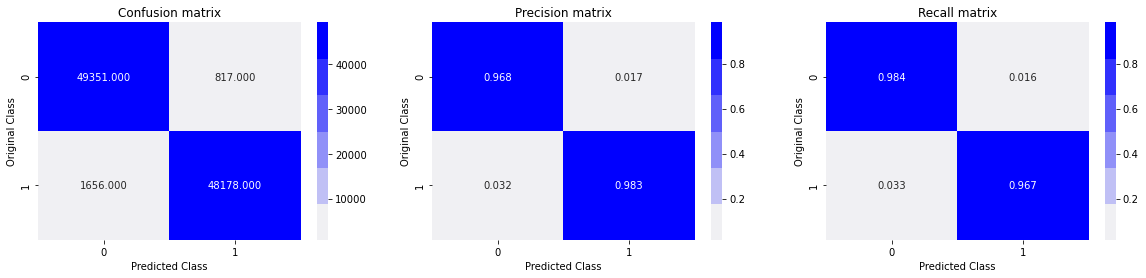

In [22]:
plot_confusion_matrix(y_train,y_pred_train)

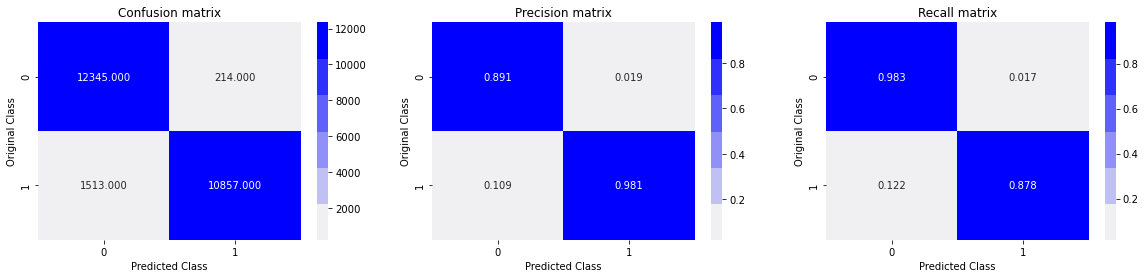

In [23]:
plot_confusion_matrix(y_test,y_pred_test)


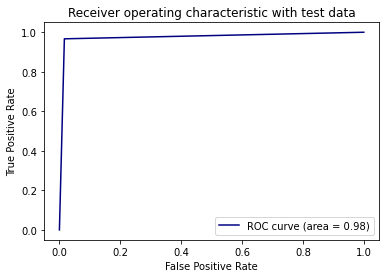

In [24]:
fpr,tpr,ths = roc_curve(y_train,y_pred_train)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

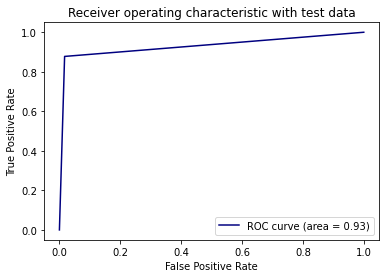

In [25]:
fpr,tpr,ths = roc_curve(y_test,y_pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

# FEATURE IMPORTANCES

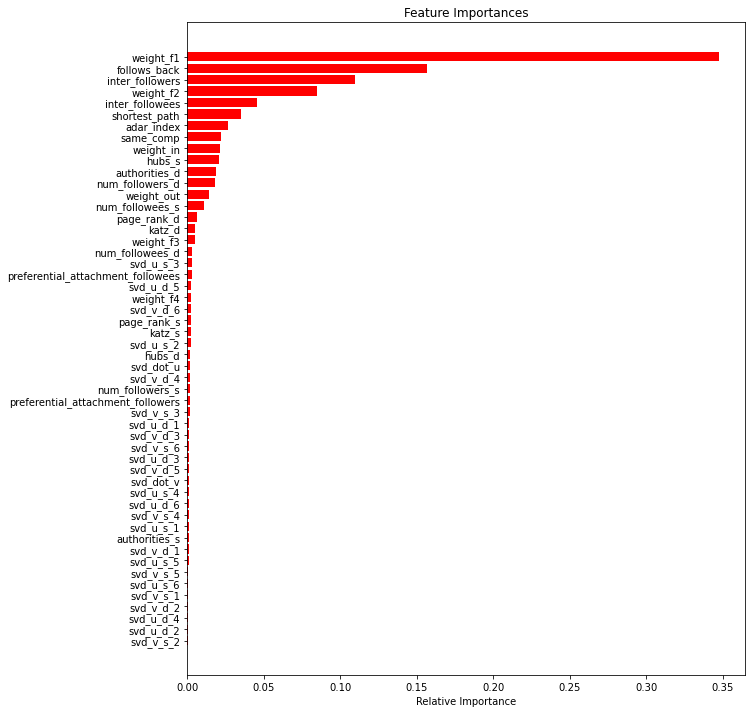

In [26]:
features = df_final_train.columns
importances = xgb_model.feature_importances_
indices = (np.argsort(importances))[-52:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()